In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH = "../../../data/dogscats/"
sz=224
arch=resnet34
bs=64

In [5]:
m=arch(True)

In [6]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [7]:
m = nn.Sequential(*children(m)[:-2],
                 nn.Conv2d(512,2,3,padding=1),
                 nn.AdaptiveAvgPool2d(1), Flatten(),
                 nn.LogSoftmax())

In [8]:
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH,bs,tfms)

In [9]:
learn = ConvLearner.from_model_data(m,data)

In [10]:
learn.freeze_to(-4)

In [11]:
m[-1].trainable

True

In [12]:
m[-4].trainable

True

In [13]:
m[-5].trainable

False

In [14]:
learn.fit(1e-2,1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.145731   0.234323   0.98      



[array([0.23432]), 0.98]

In [15]:
learn.fit(1e-2,1,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.100887   0.099585   0.989     



[array([0.09959]), 0.989]

### Class Activation Maps (CAM)

In [16]:
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [17]:
x,y = next(iter(data.val_dl))
x,y = x[None,1],y[None,1]
vx=Variable(x.cuda(),requires_grad=True)

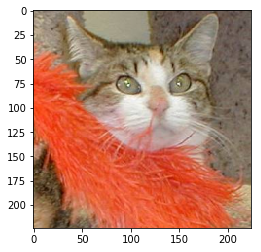

In [18]:
dx=data.val_ds.denorm(x)[0]
plt.imshow(dx)

In [21]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]);py

array([1., 0.], dtype=float32)

In [22]:
feat = np.maximum(0,sf.features[0])
feat.shape

(2, 7, 7)

In [23]:
f2 = np.dot(np.rollaxis(feat,0,3),py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.06908, 0.18628, 0.3359 , 0.41236, 0.39334, 0.30427, 0.16821],
       [0.15166, 0.37222, 0.61281, 0.73332, 0.69122, 0.53443, 0.29014],
       [0.28648, 0.57665, 0.86508, 1.     , 0.96032, 0.7483 , 0.41128],
       [0.37106, 0.63107, 0.84742, 0.93   , 0.87611, 0.69258, 0.38687],
       [0.44082, 0.57127, 0.64479, 0.64278, 0.59601, 0.47293, 0.26259],
       [0.44481, 0.45156, 0.3634 , 0.26477, 0.22004, 0.17473, 0.08811],
       [0.28819, 0.25307, 0.15081, 0.04752, 0.01626, 0.     , 0.     ]], dtype=float32)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


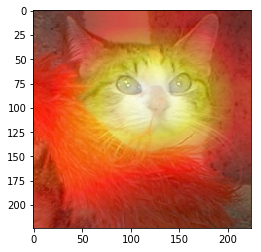

In [26]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2,dx.shape),alpha=0.5,cmap='hot')